#Flood Prediction

Import Required Libraries

In [35]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

## Telemetri Data

In [36]:
def gsheet_to_csv(url: str):
  sheet_url = url
  csv = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
  return csv

df_telemetri_rainfall = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1nI8m27noE1mMiXQXde8jyXD6-qhuMQ2tE-gXxBkuxi4/edit#gid=0"))
df_telemetri_rainfall

,Location,Date,Time,Rainfall,Status
0,Sumur Batu,15-Jul-20,14:00,0.00 mm,Cerah
1,Sumur Batu,15-Jul-20,15:00,0.00 mm,Cerah\
2,Sumur Batu,16-Jul-20,7:00,0.00 mm,Cerah
3,Sumur Batu,17-Jul-20,4:00,0.00 mm,Cerah
4,Sumur Batu,17-Jul-20,6:00,0.00 mm,Cerah
...,...,...,...,...,...
182880,Cimanggu,28-Jan-21,3:00,0.00 mm,Cerah
182881,Cimanggu,28-Jan-21,5:00,0.00 mm,Cerah
182882,Cimanggu,28-Jan-21,7:00,0.00 mm,Cerah
182883,Cimanggu,28-Jan-21,8:00,12.00 mm,Lebat


In [37]:
df_telemetri_waterlevel = pd.read_csv(gsheet_to_csv("https://docs.google.com/spreadsheets/d/1xy16th0oBqQ9kux8XGKmkk6AO1flGq1hj1kYqDLn4YI/edit#gid=0"))
df_telemetri_waterlevel.rename(columns = {'Water Level (cm)': 'water_level', 'Date ':'Date'}, inplace = True)
df_telemetri_waterlevel

,Location,Date,Time,water_level
0,Cileungsi,2-Jun-19,0:00,34 cm
1,Cileungsi,2-Jun-19,1:00,34 cm
2,Cileungsi,2-Jun-19,2:00,34 cm
3,Cileungsi,2-Jun-19,3:00,34 cm
4,Cileungsi,2-Jun-19,4:00,34 cm
...,...,...,...,...
129208,Pondok Kelapa,22 Jan 2021,5:00,-188 cm
129209,Pondok Kelapa,22 Jan 2021,6:00,-188 cm
129210,Pondok Kelapa,22 Jan 2021,7:00,-188 cm
129211,Pondok Kelapa,22 Jan 2021,8:00,-188 cm


In [38]:
# Pandas Left Join is Out of Memory
# pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
# Let's try to use sql

**Pandas Left Join is Out of Memory**
```python
pd.merge(df_telemetri_rainfall, df_telemetri_waterlevel, how="left", on="Location")
```
Let's try to use sql instead

In [39]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///./db.sqlite3', echo=False)

In [40]:
# Save to sql
df_telemetri_waterlevel.to_sql("telemetri_waterlevel", if_exists="replace", con=engine)
df_telemetri_rainfall.to_sql("telemetri_rainfall", if_exists="replace", con=engine)

In [41]:
# check length
print(len(df_telemetri_rainfall))
print(len(df_telemetri_waterlevel))

182885
129213


Join operations ini untuk menggabungkan data dengan cara mengambil semua data yang memiliki nilai **water_level** dan **Rainfall** (jika ada label data banjir dari PUPR)
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time

UNION

SELECT 
  tw.Date AS Date,
  tw.Time AS Time,
  tw.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_waterlevel AS tw
LEFT JOIN telemetri_rainfall AS tr
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```
Namun karena menggunakan asumsi bahwa jika **RainfallStatus** == lebat  sebagai label banjir maka digunakan join ini
```
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
```

In [42]:
query = engine.execute('''
SELECT 
  tr.Date AS Date,
  tr.Time AS Time,
  tr.Location AS Location,
  tr.Rainfall AS Rainfall,
  tr.Status AS RainfallStatus,
  tw.water_level AS WaterLevel
FROM telemetri_rainfall AS tr
LEFT JOIN telemetri_waterlevel AS tw
ON tr.Location = tw.Location AND tr.Date = tw.Date AND tr.Time = tw.Time
''')
df_tmrain_tmwater = pd.DataFrame(query.fetchall())
df_tmrain_tmwater.columns = query.keys()
df_tmrain_tmwater

,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
0,15-Jul-20,14:00,Sumur Batu,0.00 mm,Cerah,None
1,15-Jul-20,15:00,Sumur Batu,0.00 mm,Cerah\,None
2,16-Jul-20,7:00,Sumur Batu,0.00 mm,Cerah,None
3,17-Jul-20,4:00,Sumur Batu,0.00 mm,Cerah,None
4,17-Jul-20,6:00,Sumur Batu,0.00 mm,Cerah,None
...,...,...,...,...,...,...
182880,28-Jan-21,3:00,Cimanggu,0.00 mm,Cerah,None
182881,28-Jan-21,5:00,Cimanggu,0.00 mm,Cerah,None
182882,28-Jan-21,7:00,Cimanggu,0.00 mm,Cerah,None
182883,28-Jan-21,8:00,Cimanggu,12.00 mm,Lebat,None


In [43]:
df_tmrain_tmwater.describe()

,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
count,182885,182882,182885,182882,182882,9368
unique,1221,24,19,297,9,20
top,11-Sep-20,12:00,Bendungan Gintung,0.00 mm,Cerah,"9,690 cm"
freq,384,7776,19218,173749,173669,2558


## Preprocessing Data

Number of Missing Value 

In [44]:
df_tmrain_tmwater.isnull().sum() 

Date                   0
Time                   3
Location               0
Rainfall               3
RainfallStatus         3
WaterLevel        173517
dtype: int64

In [45]:
df_tmrain_tmwater['RainfallStatus'].unique()

array(['Cerah', 'Cerah\\', 'Lebat', 'Ringan', 'Sedang', 'Sangat Lebat',
       'Bright', 'Is', 'Light', None], dtype=object)

In [46]:
# Clean Column RainfallStatus
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Cerah\\', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Light', 'RainfallStatus'] = "Ringan"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Is', 'RainfallStatus'] = "Sedang"
df_tmrain_tmwater.loc[df_tmrain_tmwater['RainfallStatus']=='Bright', 'RainfallStatus'] = "Cerah"
df_tmrain_tmwater = df_tmrain_tmwater[df_tmrain_tmwater['RainfallStatus'].notna()]
df_tmrain_tmwater['RainfallStatus'].unique()

array(['Cerah', 'Lebat', 'Ringan', 'Sedang', 'Sangat Lebat'], dtype=object)

### Data metrics defenition
* Rainfall (mm)

  1mm rainfall means every one square meter area is filled with the water of height 1mm.
  1 square meter = 1000mm length ×1000mm breath
  So 1mm rain means 1000mm length × 1000mm breath × 1mm height = 1litre of water.
  Every square meter has one litre of water

In [47]:
df_tmrain_tmwater[df_tmrain_tmwater['WaterLevel'].notna()][df_tmrain_tmwater['RainfallStatus'] == "Lebat"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
119714,16-Jan-20,15:00,Bendungan Gintung,11.00 mm,Lebat,"9,660 cm"
119751,18-Jan-20,4:00,Bendungan Gintung,13.00 mm,Lebat,"9,660 cm"
119897,24-Jan-20,9:00,Bendungan Gintung,18.00 mm,Lebat,"9,670 cm"
119954,26-Jan-20,18:00,Bendungan Gintung,13.00 mm,Lebat,"9,650 cm"
120029,29-Jan-20,23:00,Bendungan Gintung,11.00 mm,Lebat,"9,650 cm"
...,...,...,...,...,...,...
126835,20-Nov-20,16:00,Bendungan Gintung,12.00 mm,Lebat,"9,660 cm"
127061,30-Nov-20,10:00,Bendungan Gintung,13.00 mm,Lebat,"9,630 cm"
127062,30-Nov-20,11:00,Bendungan Gintung,14.00 mm,Lebat,"9,630 cm"
127221,7-Dec-20,13:00,Bendungan Gintung,15.00 mm,Lebat,"9,650 cm"


In [48]:
# Convert metrics to float

from re import compile as re_compile, sub as re_sub

re_rainfall_metric = re_compile(r'[^\d.]')
re_waterlevel_metric = re_compile(r'[^\d,]')

def rainfall_metric_to_float(metric):
  try:
    return float(re_rainfall_metric.sub('', metric))
  except Exception as err:
    return -1.0
def waterlevel_metric_to_float(metric):
  try:
    return float(re_sub(r',', '', re_waterlevel_metric.sub('', metric)))
  except Exception as err:
    return -1.0
ds_tmrain_tmwater_rainfall = df_tmrain_tmwater.apply(lambda row: rainfall_metric_to_float(str(row["Rainfall"])), axis=1)
ds_tmrain_tmwater_waterlevel = df_tmrain_tmwater.apply(lambda row: waterlevel_metric_to_float(str(row["WaterLevel"])), axis=1)

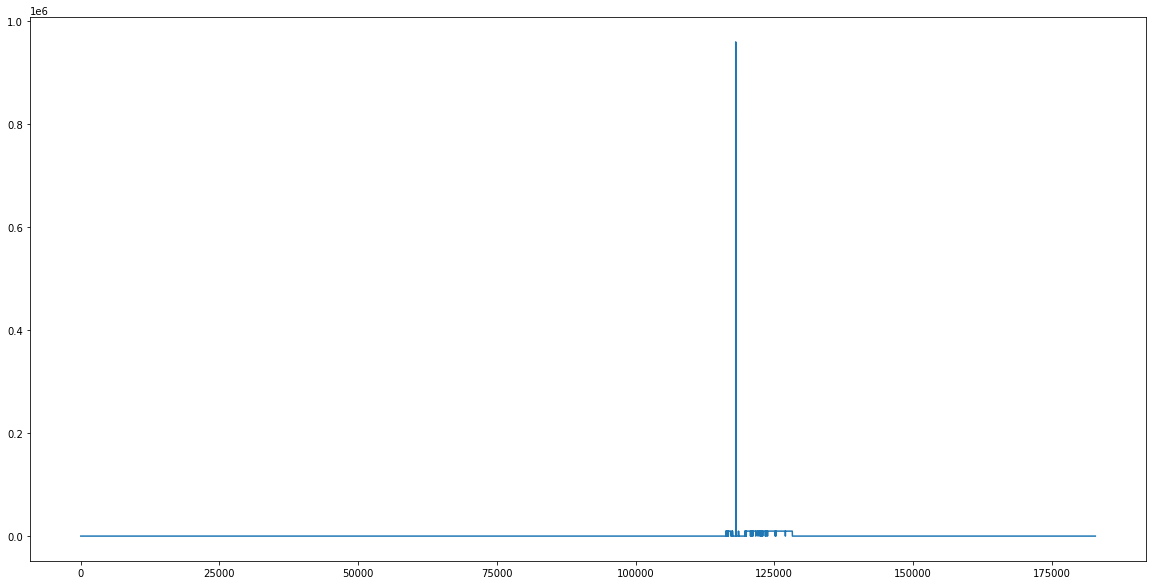

In [49]:
ds_tmrain_tmwater_waterlevel.plot()

In [50]:
water_level_value_replacement = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel != -1].std()
water_level_value_replacement

9805.946814084187

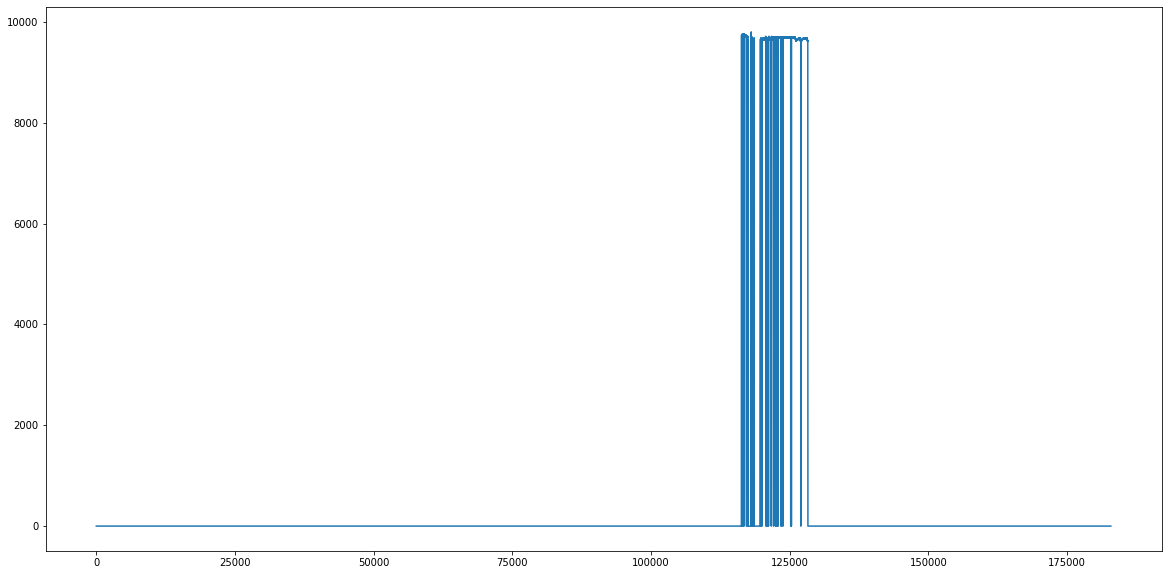

In [51]:
# There is high spikes (probably measurement error)
max_idx = ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == ds_tmrain_tmwater_waterlevel.max()].index[0]
ds_tmrain_tmwater_waterlevel[max_idx] = water_level_value_replacement
ds_tmrain_tmwater_waterlevel.plot()

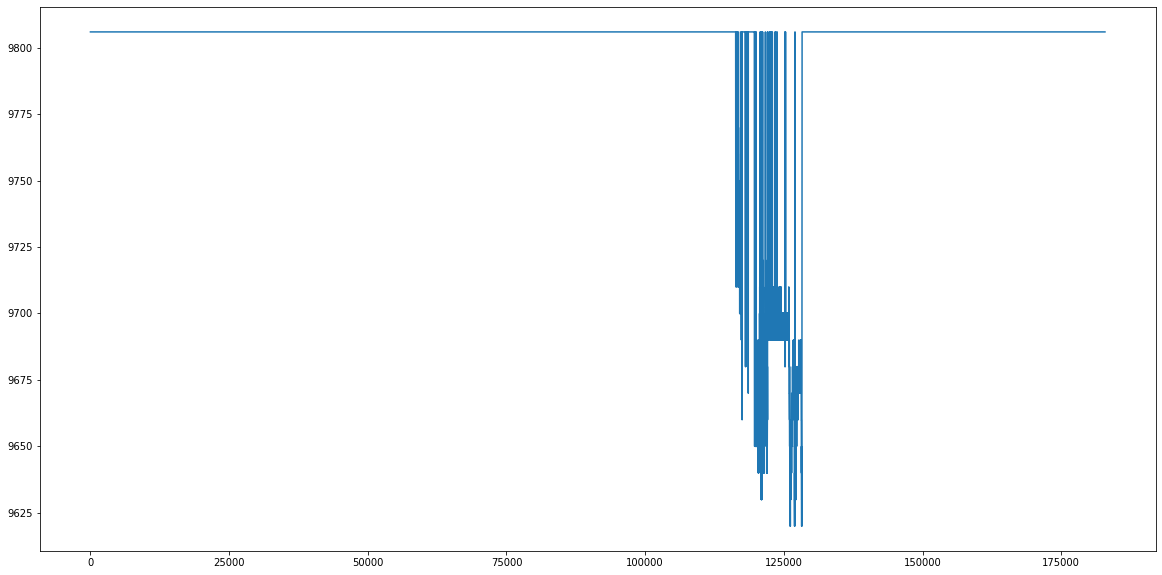

In [52]:
# Let's also replace missing value (-1) there
ds_tmrain_tmwater_waterlevel[ds_tmrain_tmwater_waterlevel == -1] = water_level_value_replacement
ds_tmrain_tmwater_waterlevel.plot()

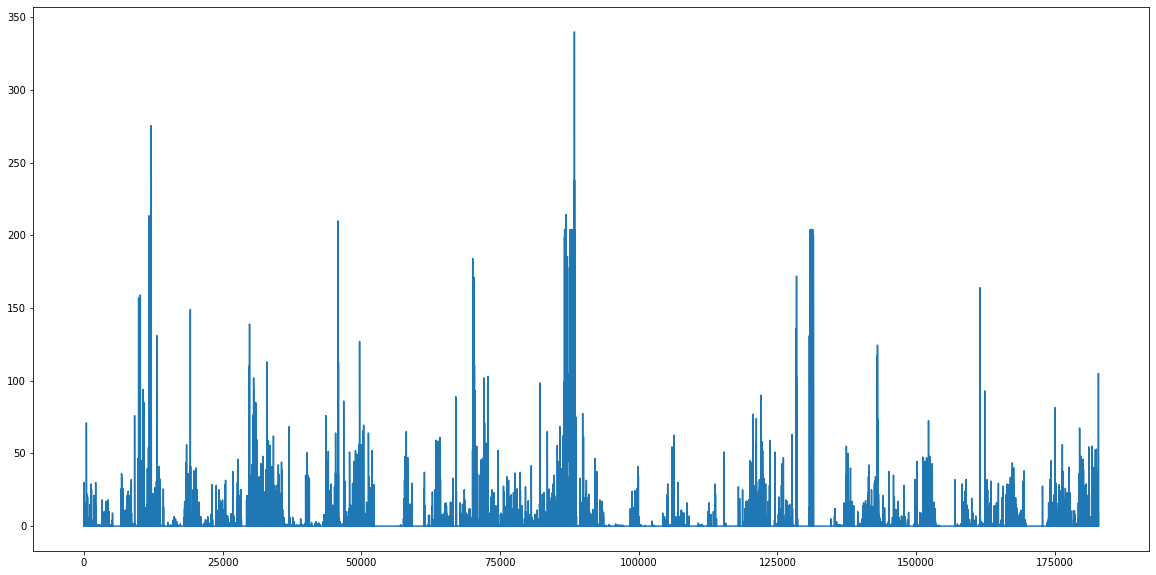

In [53]:
ds_tmrain_tmwater_rainfall.plot()

In [54]:
# Looks good, let's join to main df
df_tmrain_tmwater["WaterLevel"] = ds_tmrain_tmwater_waterlevel
df_tmrain_tmwater["Rainfall"] = ds_tmrain_tmwater_rainfall
df_tmrain_tmwater

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
0,15-Jul-20,14:00,Sumur Batu,0.0,Cerah,9805.946814
1,15-Jul-20,15:00,Sumur Batu,0.0,Cerah,9805.946814
2,16-Jul-20,7:00,Sumur Batu,0.0,Cerah,9805.946814
3,17-Jul-20,4:00,Sumur Batu,0.0,Cerah,9805.946814
4,17-Jul-20,6:00,Sumur Batu,0.0,Cerah,9805.946814
...,...,...,...,...,...,...
182880,28-Jan-21,3:00,Cimanggu,0.0,Cerah,9805.946814
182881,28-Jan-21,5:00,Cimanggu,0.0,Cerah,9805.946814
182882,28-Jan-21,7:00,Cimanggu,0.0,Cerah,9805.946814
182883,28-Jan-21,8:00,Cimanggu,12.0,Lebat,9805.946814


In [55]:
from datetime import datetime
def convert_to_datetime(date: str):
  try:
    return datetime.strptime(date, '%d-%b-%y')
  except ValueError:
    return datetime.strptime(date, '%d-%B-%y')

df_tmrain_tmwater['Date'] = df_tmrain_tmwater.apply(lambda row: convert_to_datetime(row["Date"]), axis=1)
df_tmrain_tmwater

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
0,2020-07-15,14:00,Sumur Batu,0.0,Cerah,9805.946814
1,2020-07-15,15:00,Sumur Batu,0.0,Cerah,9805.946814
2,2020-07-16,7:00,Sumur Batu,0.0,Cerah,9805.946814
3,2020-07-17,4:00,Sumur Batu,0.0,Cerah,9805.946814
4,2020-07-17,6:00,Sumur Batu,0.0,Cerah,9805.946814
...,...,...,...,...,...,...
182880,2021-01-28,3:00,Cimanggu,0.0,Cerah,9805.946814
182881,2021-01-28,5:00,Cimanggu,0.0,Cerah,9805.946814
182882,2021-01-28,7:00,Cimanggu,0.0,Cerah,9805.946814
182883,2021-01-28,8:00,Cimanggu,12.0,Lebat,9805.946814


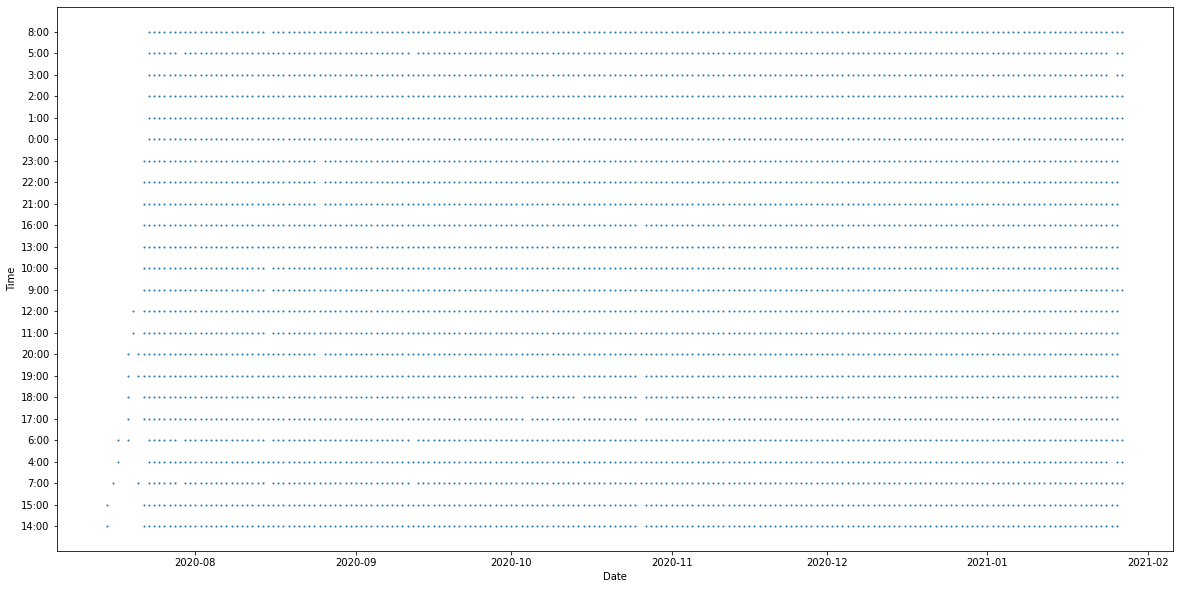

In [56]:
# See if time is regularly updated

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

df_tmrain_tmwater[df_tmrain_tmwater["Location"] == "Sumur Batu"].plot("Date", "Time", kind="scatter", s=1)

There are many missing values! (Not regular)

Let's just take by date and not by time

In [57]:
df_tmrain_tmwater_days = df_tmrain_tmwater.sort_values("Rainfall", ascending=False).groupby(["Location", "Date"]).head(1)
df_tmrain_tmwater_days

,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel
88413,2020-08-03,3:00,Kampus UI,340.0,Sangat Lebat,9805.946814
12135,2019-02-11,16:00,Cawang,275.5,Lebat,9805.946814
88435,2020-08-04,1:00,Kampus UI,216.5,Sangat Lebat,9805.946814
86852,2020-05-20,6:00,Kampus UI,214.5,Sangat Lebat,9805.946814
11722,2019-01-25,10:00,Cawang,213.5,Lebat,9805.946814
...,...,...,...,...,...,...
62148,2020-08-08,8:00,Kampung Kelapa,0.0,Cerah,9805.946814
62063,2020-08-04,19:00,Kampung Kelapa,0.0,Cerah,9805.946814
62005,2020-08-02,9:00,Kampung Kelapa,0.0,Cerah,9805.946814
62321,2020-08-15,23:00,Kampung Kelapa,0.0,Cerah,9805.946814


In [58]:
# Asumsi Labeling
df_tmrain_tmwater_days['Banjir'] = df_tmrain_tmwater_days.apply(lambda row: 1 if str(row['RainfallStatus']).lower() == "lebat" or str(row['RainfallStatus']).lower() == "sangat lebat" else 0, axis=1)
df_tmrain_tmwater_days

,Date,Time,Location,Rainfall,RainfallStatus,WaterLevel,Banjir
88413,2020-08-03,3:00,Kampus UI,340.0,Sangat Lebat,9805.946814,1
12135,2019-02-11,16:00,Cawang,275.5,Lebat,9805.946814,1
88435,2020-08-04,1:00,Kampus UI,216.5,Sangat Lebat,9805.946814,1
86852,2020-05-20,6:00,Kampus UI,214.5,Sangat Lebat,9805.946814,1
11722,2019-01-25,10:00,Cawang,213.5,Lebat,9805.946814,1
...,...,...,...,...,...,...,...
62148,2020-08-08,8:00,Kampung Kelapa,0.0,Cerah,9805.946814,0
62063,2020-08-04,19:00,Kampung Kelapa,0.0,Cerah,9805.946814,0
62005,2020-08-02,9:00,Kampung Kelapa,0.0,Cerah,9805.946814,0
62321,2020-08-15,23:00,Kampung Kelapa,0.0,Cerah,9805.946814,0


In [59]:
# Berapa banjir ya
df_tmrain_tmwater_days["Banjir"].sum()

976

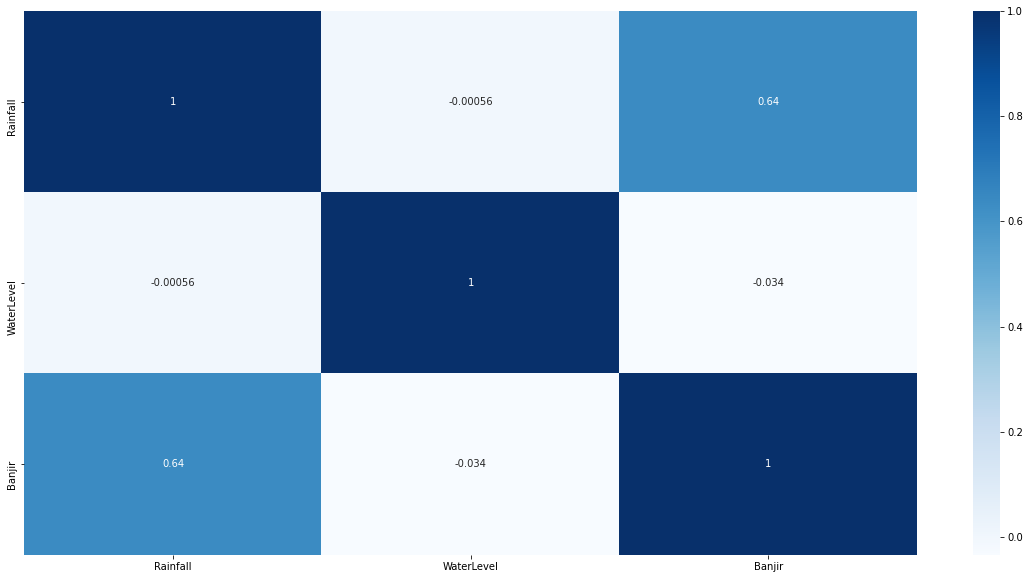

In [60]:
# Bagaimana korelasi WaterLevel, Rainfall, dan Banjir?
import seaborn as sb
sb.heatmap(df_tmrain_tmwater_days[["Rainfall", "WaterLevel", "Banjir"]].corr(), cmap="Blues", annot=True)

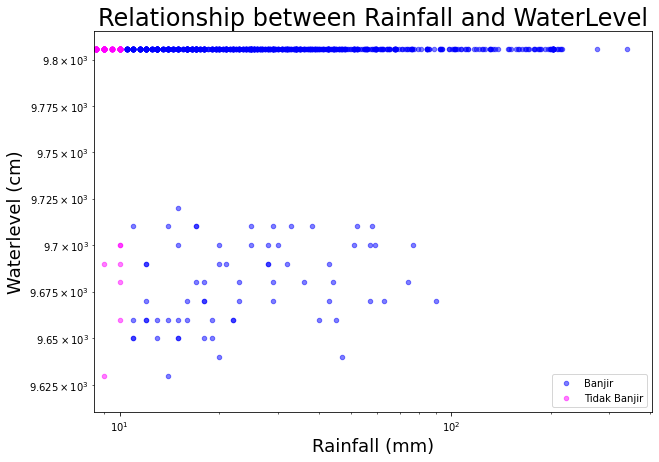

In [61]:
ax1 = df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 1].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='blue', alpha=0.5, figsize=(10, 7), logx=True, logy=True)
df_tmrain_tmwater_days[df_tmrain_tmwater_days['Banjir'] == 0].plot(kind='scatter', x='Rainfall', y='WaterLevel', color='magenta', alpha=0.5, figsize=(10 ,7), ax=ax1, logx=True, logy=True)
plt.legend(labels=['Banjir', 'Tidak Banjir'])
plt.title('Relationship between Rainfall and WaterLevel', size=24)
plt.xlabel('Rainfall (mm)', size=18)
plt.ylabel('Waterlevel (cm)', size=18);

Tidak terlalu bagus untuk WaterLevel vs Banjir (Mungkin karena data tidak lengkap)


Karena tidak bagus korelasinya, maka digunakan satu kolom saja yakni 

X[Rainfall]

Y[Banjir]



## Create Model

### Models for detecting banjir or tidak

In [62]:
import pickle
class Transformer:
  """Convert non numeric categorical data to numeric value
  """
  def __init__(self):
    self.mapping_keys = {}

  def fit_transform(self, df):
    columns = df.columns.values
    self.mapping_keys = {}

    for column in columns:
      text_digit_vals = {}
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        column_contents = df[column].values.tolist()
        unique_elements = sorted(set(column_contents), key=lambda x: str(x))
        x = 0
        for unique in unique_elements:
          if unique not in text_digit_vals:
            text_digit_vals[unique] = x
            x += 1
        df[column] = df.apply(lambda row: text_digit_vals[row[column]], axis=1)
        self.mapping_keys[column] = text_digit_vals

      return df

  def transform(self, df):
    columns = df.columns.values
    for column in columns:
      if df[column].dtype != np.int64 and df[column].dtype != np.float64:
        df[column] = df.apply(lambda row: self.mapping_keys[column][row[column]], axis=1)
    return df
  
  def save_mapping(self, location):
    pickle.dump(self.mapping_keys, open(location, "wb"))

In [63]:
# Convert categorical data to mapping numbers

transformer = Transformer()
df_banjir = transformer.fit_transform(df_tmrain_tmwater_days[["Location", "Rainfall", "Banjir"]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
# Training
import numpy as np
from sklearn import preprocessing, model_selection, neighbors # cross_validation has been deprecated so use model_selection instead
import pandas as pd

X = np.array(df_banjir.drop(['Banjir'], 1))
y = np.array(df_banjir['Banjir'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2)

clf = neighbors.KNeighborsClassifier()

clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print('Accuracy=', accuracy)

Accuracy= 0.9969806763285024


In [65]:
# Predicting

def predict_banjir(input_value):
  df_banjir_to_predict = pd.DataFrame(input_value, columns=["Location", "Rainfall"])
  df_banjir_to_predict = transformer.transform(df_banjir_to_predict)
  print('Input=',input_value)
  predictions = clf.predict(df_banjir_to_predict)
  print('Predictions', predictions)
  return predictions

predict_banjir([["Cawang", 213.5],["Kampung Kelapa", 0],["Cawang", 213.5]])

Input= [['Cawang', 213.5], ['Kampung Kelapa', 0], ['Cawang', 213.5]]
Predictions [1 0 1]


array([1, 0, 1])

## Rainfall Forecasting Model

In [82]:
def get_rainfall_by_location(location):
  return df_tmrain_tmwater_days[["Date", "Location", "Rainfall"]][df_tmrain_tmwater_days["Location"] == location].sort_values("Date")

df_tmrain_tmwater_days["Location"].unique()

array(['Kampus UI', 'Cawang', 'Kemensos', 'Cengkareng Drain', 'Manggarai',
       'Bojong Murni', 'Gunung Mas', 'Situ Parigi', 'Gadog', 'Cimanggu',
       'Cibinong', 'Bendungan Gintung', 'Pasir Jaya', 'Villa Pamulang',
       'Sumur Batu', 'Kampung Kelapa', 'Jeruk Purut', 'Lengkong Barang',
       'Jatijajar'], dtype=object)

In [155]:
# Create feature using sliding window
location = "Kampung Kelapa"
df = get_rainfall_by_location(location)
df

,Date,Location,Rainfall
51860,2018-06-04,Kampung Kelapa,0.0
51864,2018-07-20,Kampung Kelapa,0.0
51876,2018-07-21,Kampung Kelapa,0.0
51896,2018-07-22,Kampung Kelapa,52.0
51909,2018-07-23,Kampung Kelapa,0.0
...,...,...,...
66069,2021-01-23,Kampung Kelapa,16.5
66081,2021-01-24,Kampung Kelapa,0.0
66087,2021-01-25,Kampung Kelapa,4.0
66112,2021-01-26,Kampung Kelapa,4.0


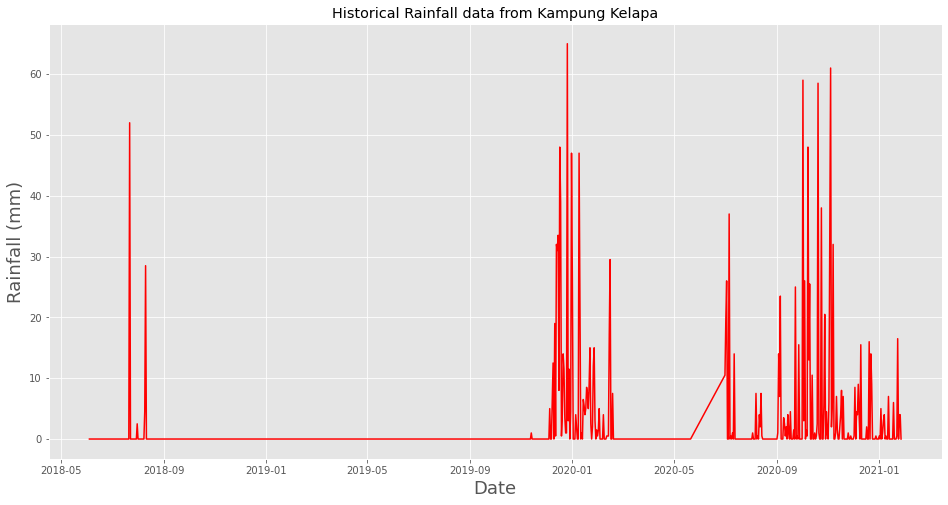

In [156]:
# Plot data
# plotting the data
plt.figure(figsize=(16, 8))
plt.title('Historical Rainfall data from %s'%location)
plt.plot(df["Date"],df['Rainfall'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Rainfall (mm)', fontsize=18)
plt.show()

In [157]:
# create new data frame with only 'Rainfall' column
data = df[['Rainfall']]
dataset = data.values # convert the data frame to numpy array
trainning_data_len = math.ceil(len(dataset)*.8) # number of rows to train model
trainning_data_len

512

In [158]:
train_data = dataset[0:trainning_data_len, :]
# Split the data into x_train, y_train datasets
x_train = []
y_train = []

window = 30 # can predict 30 days ahead

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])
    if i<=window:
        print(x_train)
        print(y_train)
        print()

[array([ 0. ,  0. ,  0. , 52. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  2.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4.5,
       28.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])]
[0.0]



In [159]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [160]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression(n_jobs=-1)
clf.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [161]:
test_data = dataset[trainning_data_len-window:, :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[trainning_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])

# convert the data  to numpy array
x_test = np.array(x_test)

forecast_set = clf.predict(x_test)

In [162]:
rmse = np.sqrt(np.mean(forecast_set - y_test)**2)
rmse

0.8829854367071062

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Unrecognized location 'upper_center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  del sys.path[0]


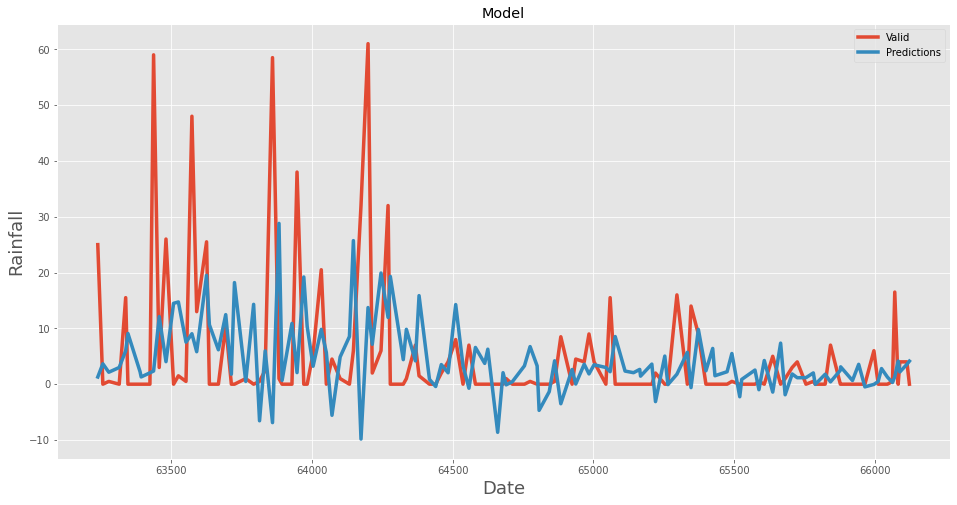

In [163]:
# plot the data
train = data[:trainning_data_len]
valid = data[trainning_data_len:]
valid['Predictions'] = forecast_set

# visalization of the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Rainfall', fontsize=18)
# plt.plot(train['Rainfall'], linewidth=3.5)
plt.plot(valid[['Rainfall', 'Predictions']], linewidth=3.5)
plt.legend(['Valid','Predictions'], loc='upper_center')
plt.show()

In [168]:
import pickle
pickle.dump(clf, open("mreg-predict-banjir-%s.pkl"%location, "wb"))
mcls = pickle.load( open("mreg-predict-banjir-%s.pkl"%location, "rb" ))
mcls.predict(x_test)